In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Hand cleansed market list
Hand cleaned to removed duplicates.  

In [2]:
cleansed=load_amihud_markets_price()

tsmom_model.py:146: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:148: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:33: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:36: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future versio

# Presentation to be like "Time Varying Liquidity and Momentum Profits (2015) paper

Rank by deciles, HML (8,9,10) - (1,2,3).  Save monthly returns (equal (risk?) weighted) and if you want to annualized then resample.


Then correlation matrix 
* Overall market vol?
* Market illiquidity (median Amihud through time series)


In [6]:
un_dec=quantile_portfolios_annual(amihud,cleansed)

tsmom_model.py:210: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
tsmom_model.py:211: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)].mean(axis=1)


Tring scalled performance by volatility to equal but it is a mess.  I think this highlights something is further wrong in the data. 

In [7]:
scalled_rtns=cleansed.resample(rule='m',how='last').pct_change()/pd.ewmstd(cleansed.resample(rule='m',how='last').pct_change(),125,min_periods=60)*.15
scalled_prices=scalled_rtns.cumsum()
sc_dec=quantile_portfolios_annual(amihud,scalled_prices)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=60,adjust=True,com=125).std(bias=False)
  if __name__ == '__main__':


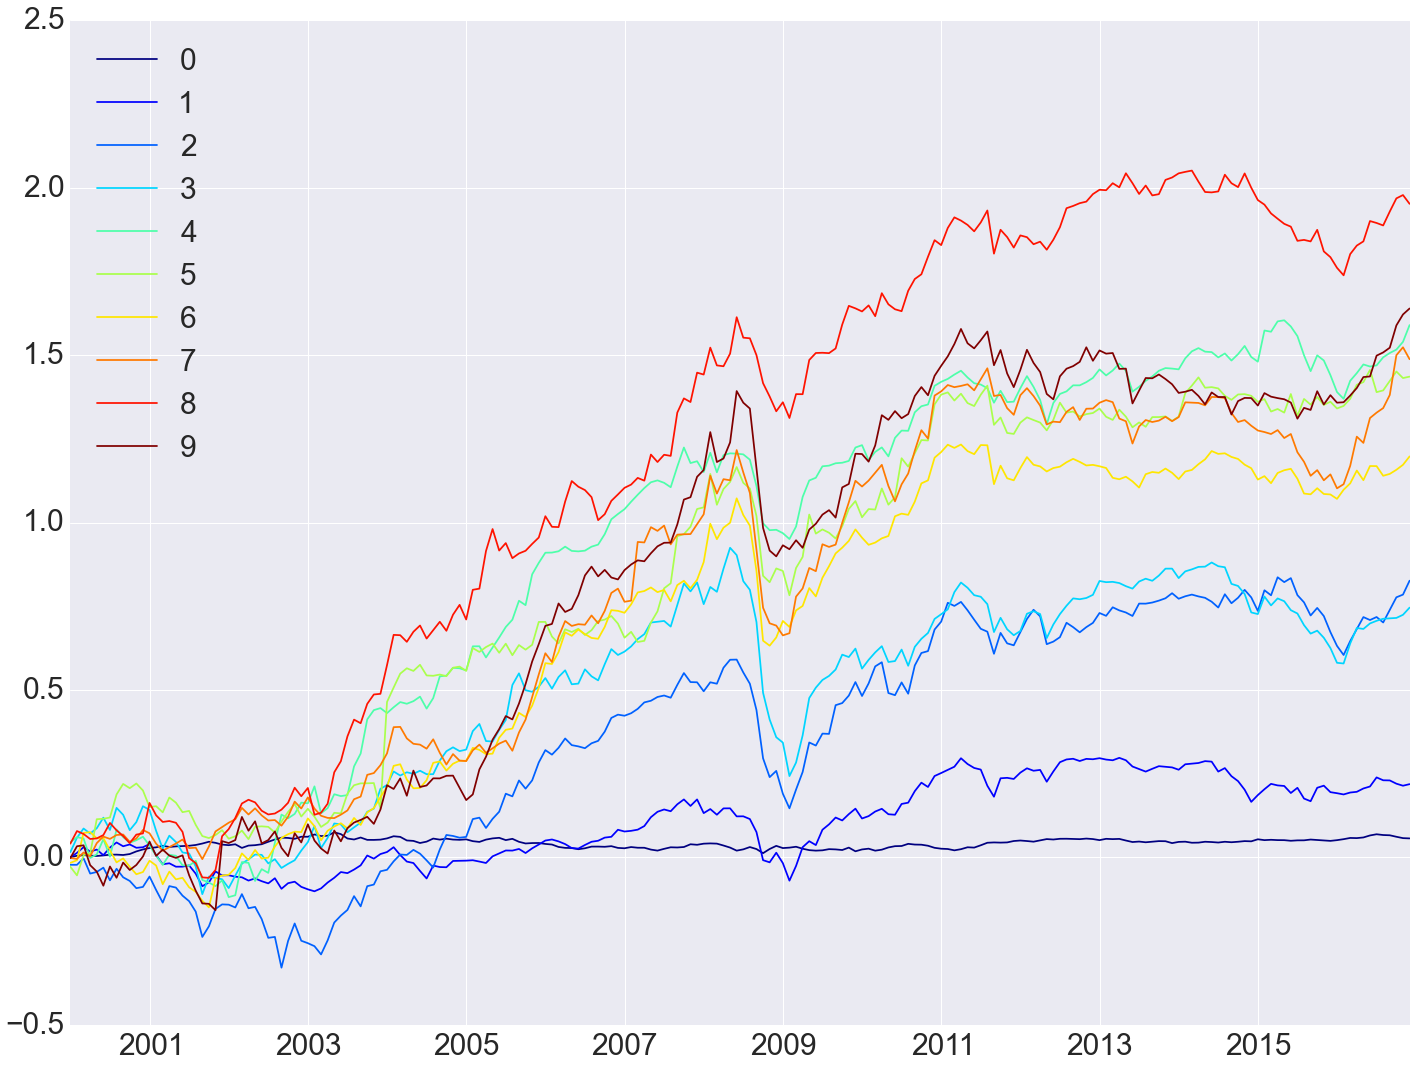

In [8]:
un_dec.dropna().cumsum().plot(colormap='jet')

# Table 1 - Data summary and descriptive table

Explination
* Highlight how portfolios were formed.  Equally weighted and formed annually or should we do monthly?
* Mention that this is excess returns (does not include fully funded positions i.e. with cash returns)

Monthly and Annual portfolio sorts:
* AR(1) returns
* CAPM alpha's and beta's 
* All the moments

# Annual portfolio sorts 

In [122]:
ex=un_dec.dropna(how='all')
en=ex.shift(-1).dropna()
en['Intercept']=1
ex=ex.ix[en.index]
coef=[]
tstat=[]
i='0'
for i in range(0,10,1):
    res=sm.OLS(ex[str(i)],en[[str(i)]]).fit()
    coef.append(res.params[str(i)])
    tstat.append(res.tvalues[str(i)])
ar1=pd.DataFrame()
ar1['Coef']=pd.Series(coef,index=ind)
ar1['Tstats']=pd.Series(tstat,index=ind)

In [171]:
ind=un_dec.dropna(how='all').index
FF=FF_monthly.ix[ind]/100.
FF['Intercept']=1
alpha=[]
beta=[]
tstat_alpha=[]
tstat_beta=[]
i='0'
for i in range(0,10,1):
    res=sm.OLS(un_dec.dropna()[str(i)],FF[['Intercept','Mkt-RF']]).fit()
    alpha.append(res.params['Intercept'])
    beta.append(res.params['Mkt-RF'])
    tstat_alpha.append(res.tvalues['Intercept'])
    tstat_beta.append(res.tvalues['Mkt-RF'])   
CAPM=pd.DataFrame()
CAPM['Alpha']=pd.Series(alpha,index=un_dec.columns)
CAPM['Alpha Tstat']=pd.Series(tstat_alpha,index=un_dec.columns)
CAPM['Beta']=pd.Series(beta,index=un_dec.columns)
CAPM['Beta Tstat']=pd.Series(tstat_beta,index=un_dec.columns)

In [176]:
res=pd.DataFrame()
res['Monthly Return']=un_dec.mean()*100
res['Standard Deviation']=un_dec.std()*math.sqrt(12)*100
res['Information Ratio']=calc_Sharpe(un_dec)
res['Skewness']=un_dec.skew()
res['Excess Kurtosis']=un_dec.kurtosis()
res['AR(1)']=ar1.Coef
res['AR(1) Tstat']=ar1.Tstats
res['CAPM Alpha (in %)']=CAPM.Alpha
res['CAPM Alpha Tstat']=CAPM['Alpha Tstat']
res['CAPM Beta (in %)']=CAPM.Beta
res['CAPM Beta Tstat']=CAPM['Beta Tstat']
res =res.round(2)
res.T

,0,1,2,3,4,5,6,7,8,9
Monthly Return,0.03,0.11,0.41,0.37,0.78,0.70,0.59,0.73,0.96,0.80
Standard Deviation,1.50,6.60,12.39,13.34,12.12,15.60,12.05,14.56,14.06,15.89
Information Ratio,0.22,0.20,0.39,0.33,0.77,0.54,0.58,0.60,0.82,0.61
Skewness,-0.26,-0.45,-0.48,-1.03,-0.00,1.48,-1.30,-0.08,0.20,-0.18
Excess Kurtosis,0.43,2.01,1.04,4.46,0.84,12.36,8.07,3.68,0.50,3.46
AR(1),0.04,0.08,0.11,0.23,0.12,-0.05,0.18,0.21,0.06,0.07
AR(1) Tstat,0.60,1.15,1.51,3.31,1.68,-0.74,2.55,3.02,0.87,1.02
CAPM Alpha (in %),0.00,-0.00,0.00,0.00,0.01,0.01,0.00,0.01,0.01,0.01
CAPM Alpha Tstat,1.17,-0.07,1.14,0.80,2.99,1.95,2.10,2.18,3.14,2.24
CAPM Beta (in %),-0.02,0.31,0.65,0.55,0.40,0.34,0.34,0.41,0.30,0.32


In [177]:
print res.T.to_latex()

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &     0 &      1 &      2 &      3 &      4 &      5 &      6 &      7 &      8 &      9 \\
\midrule
Monthly Return     &  0.03 &   0.11 &   0.41 &   0.37 &   0.78 &   0.70 &   0.59 &   0.73 &   0.96 &   0.80 \\
Standard Deviation &  1.50 &   6.60 &  12.39 &  13.34 &  12.12 &  15.60 &  12.05 &  14.56 &  14.06 &  15.89 \\
Information Ratio  &  0.22 &   0.20 &   0.39 &   0.33 &   0.77 &   0.54 &   0.58 &   0.60 &   0.82 &   0.61 \\
Skewness           & -0.26 &  -0.45 &  -0.48 &  -1.03 &  -0.00 &   1.48 &  -1.30 &  -0.08 &   0.20 &  -0.18 \\
Excess Kurtosis    &  0.43 &   2.01 &   1.04 &   4.46 &   0.84 &  12.36 &   8.07 &   3.68 &   0.50 &   3.46 \\
AR(1)              &  0.04 &   0.08 &   0.11 &   0.23 &   0.12 &  -0.05 &   0.18 &   0.21 &   0.06 &   0.07 \\
AR(1) Tstat        &  0.60 &   1.15 &   1.51 &   3.31 &   1.68 &  -0.74 &   2.55 &   3.02 &   0.87 &   1.02 \\
CAPM Alpha (in \%)  &  0.00 &  -0.00 &   0.00 &   0.00 &   0.01 &   0.01 &   0.00

# Monthly portoflio sorts

In [24]:
# Takes a long time to run, so pull a pickle
# monthly_dec=quantile_portfolios_monthly(amihud,cleansed)
monthly_dec=pd.read_pickle('monthly.pickle')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


In [184]:
ex=monthly_dec.dropna(how='all')
en=ex.shift(-1).dropna()
ind=monthly_dec.T.index
en['Intercept']=1
ex=ex.ix[en.index]
coef=[]
tstat=[]
i='0'
for i in range(0,10,1):
    res=sm.OLS(ex[str(i)],en[[str(i)]]).fit()
    coef.append(res.params[str(i)])
    tstat.append(res.tvalues[str(i)])
ar1=pd.DataFrame()
ar1['Coef']=pd.Series(coef,index=ind)
ar1['Tstats']=pd.Series(tstat,index=ind)

In [178]:
ind=monthly_dec.dropna(how='all').index
FF=FF_monthly.ix[ind]/100.
FF['Intercept']=1
alpha=[]
beta=[]
tstat_alpha=[]
tstat_beta=[]
i='0'
for i in range(0,10,1):
    res=sm.OLS(monthly_dec.dropna()[str(i)],FF[['Intercept','Mkt-RF']]).fit()
    alpha.append(res.params['Intercept'])
    beta.append(res.params['Mkt-RF'])
    tstat_alpha.append(res.tvalues['Intercept'])
    tstat_beta.append(res.tvalues['Mkt-RF'])   
CAPM=pd.DataFrame()
CAPM['Alpha']=pd.Series(alpha,index=monthly_dec.columns)
CAPM['Alpha Tstat']=pd.Series(tstat_alpha,index=monthly_dec.columns)
CAPM['Beta']=pd.Series(beta,index=monthly_dec.columns)
CAPM['Beta Tstat']=pd.Series(tstat_beta,index=monthly_dec.columns)

In [197]:
res=pd.DataFrame()
res['Monthly Return']=monthly_dec.mean()*100
res['Standard Deviation']=monthly_dec.std()*math.sqrt(12)*100
res['Information Ratio']=calc_Sharpe(monthly_dec)
res['Skewness']=monthly_dec.skew()
res['Excess Kurtosis']=monthly_dec.kurtosis()
res['CAPM Alpha (in %)']=CAPM.Alpha
res['CAPM Alpha Tstat']=CAPM['Alpha Tstat']
res['CAPM Beta (in %)']=CAPM.Beta
res['CAPM Beta Tstat']=CAPM['Beta Tstat']
res['AR(1)']=ar1.Coef
res['AR(1) Tstat']=ar1.Tstats
res = res.round(4)
res.T

,0,1,2,3,4,5,6,7,8,9
Monthly Return,-0.0078,0.2453,0.2306,0.6602,0.5839,0.5634,0.6196,0.6439,0.8022,0.7633
Standard Deviation,1.8119,6.1304,12.8193,14.4185,12.5680,13.6930,10.8641,16.1029,15.0029,17.6808
Information Ratio,-0.0515,0.4801,0.2159,0.5495,0.5575,0.4937,0.6844,0.4798,0.6416,0.5181
Skewness,-0.5960,-0.5088,-0.4358,-0.4072,0.0419,-0.3849,0.1318,1.5349,0.0411,-0.4739
Excess Kurtosis,3.8777,1.0420,1.6189,4.0155,0.3077,3.3746,1.8424,13.4999,0.4707,6.1670
CAPM Alpha (in %),0.0000,0.0014,0.0000,0.0048,0.0043,0.0044,0.0053,0.0050,0.0069,0.0064
CAPM Alpha Tstat,0.0128,1.7493,0.0256,1.9824,2.0243,1.7310,2.5877,1.6733,2.4045,1.8795
CAPM Beta (in %),-0.0238,0.2963,0.6546,0.5129,0.4528,0.3567,0.2519,0.4072,0.3239,0.3501
CAPM Beta Tstat,-2.9802,16.4075,18.8556,9.5157,9.6939,6.3400,5.5289,6.1200,5.0977,4.6290
AR(1),0.0332,-0.0546,0.1900,0.1931,0.0422,-0.0037,0.0928,0.1367,0.0059,0.1517


In [193]:
print res.round(2).T.to_latex()

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &     0 &      1 &      2 &      3 &      4 &      5 &      6 &      7 &      8 &      9 \\
\midrule
Monthly Return     & -0.01 &   0.25 &   0.23 &   0.66 &   0.58 &   0.56 &   0.62 &   0.64 &   0.80 &   0.76 \\
Standard Deviation &  1.81 &   6.13 &  12.82 &  14.42 &  12.57 &  13.69 &  10.86 &  16.10 &  15.00 &  17.68 \\
Information Ratio  & -0.05 &   0.48 &   0.22 &   0.55 &   0.56 &   0.49 &   0.68 &   0.48 &   0.64 &   0.52 \\
Skewness           & -0.60 &  -0.51 &  -0.44 &  -0.41 &   0.04 &  -0.38 &   0.13 &   1.53 &   0.04 &  -0.47 \\
Excess Kurtosis    &  3.88 &   1.04 &   1.62 &   4.02 &   0.31 &   3.37 &   1.84 &  13.50 &   0.47 &   6.17 \\
CAPM Alpha (in \%)  &  0.00 &   0.00 &   0.00 &   0.00 &   0.00 &   0.00 &   0.01 &   0.00 &   0.01 &   0.01 \\
CAPM Alpha Tstat   &  0.01 &   1.75 &   0.03 &   1.98 &   2.02 &   1.73 &   2.59 &   1.67 &   2.40 &   1.88 \\
CAPM Beta (in \%)   & -0.02 &   0.30 &   0.65 &   0.51 &   0.45 &   0.36 &   0.2

In [188]:
monthly_dec.to_pickle('monthly.pickle')

# Get Fama French factor data

In [137]:
FF_daily=quandl.get('KFRENCH/FACTORS_D')
FF_monthly=quandl.get('KFRENCH/FACTORS_M')

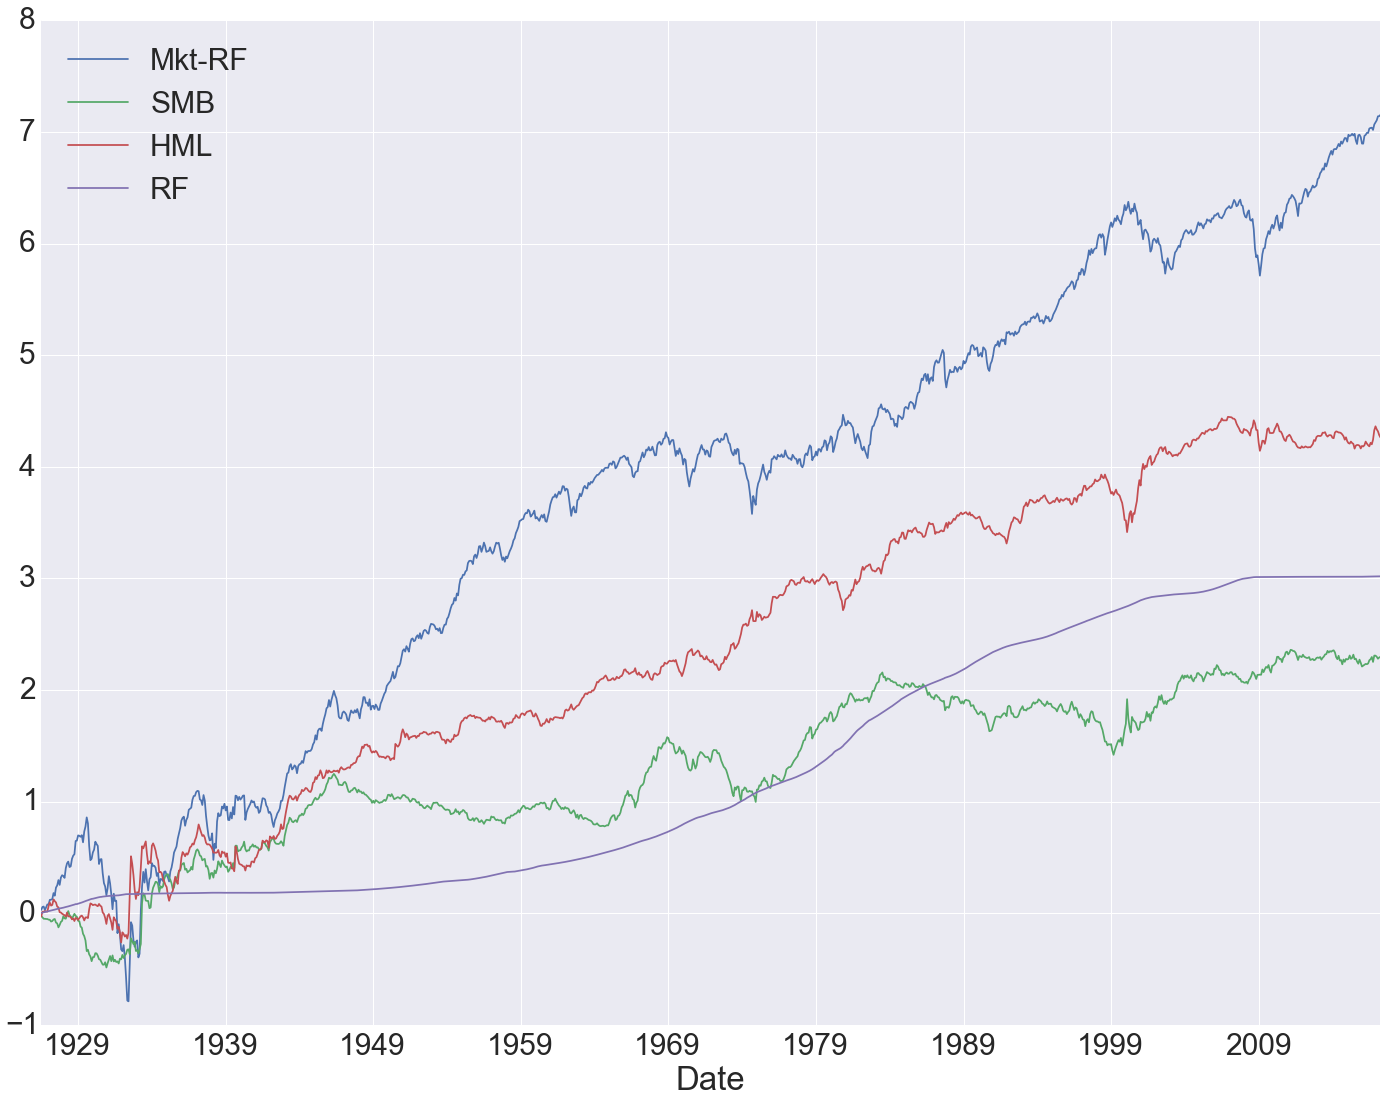

In [139]:
(FF_monthly/100.).cumsum().plot()